# WAF 2023
Analysis of passenger airline timeliness and determinants of on-time performance.

In [1]:
# supress FutureWarnings from sklearn, pandas, and seaborn regarding deprecation
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# load relevant libraries
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer

from os import cpu_count
from datetime import date
from sklearn_pandas import DataFrameMapper
from sklearn.impute import IterativeImputer
from pandas.api.types import is_object_dtype
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score, f1_score


def getSeason(data):
    """
    A function which takes a row in a pandas dataframe, extracts the date of the flight, 
    and converts it to the appropriate season in the year (based on North American hemisphere)

    Parameters
    ----------
    data (pd.DataFrame) : an observation from a pandas dataframe that contains the month and day as int types under `MONTH` and `DAY_OF_MONTH`, respectively

    Returns
    -------
    season (str) : one of 'winter', 'spring', 'summer', or 'autumn', the season the input date is associated with
    """
    year = 2000 # set to 2000 to support Feb. 29
    seasons = [
        ("winter", date(year, 1, 1), date(year, 2, 29)),
        ("winter", date(year, 12, 1), date(year, 12, 31)),
        ("spring", date(year, 3, 1), date(year, 5, 31)),
        ("summer", date(year, 6, 1), date(year, 8, 31)),
        ("autumn", date(year, 9, 1), date(year, 11, 30)),
    ]
    curr_date = date(year, data["MONTH"], data["DAY_OF_MONTH"])


    for season in seasons:
        if season[1]<= curr_date and curr_date <= season[2]:
            return season[0]


def convertCategorical(data, coded=False):
    """
    A function which takes a column in a pandas dataframe, and converts the data from 
    object dtype to categorical

    Parameters
    ----------
    data (pd.DataFrame) : a projection from a pandas dataframe

    Returns
    -------
    col (pd.Series) : a pandas Series which has been converted to Categorical
    """
    if data.name == "DAY_OF_WEEK" or is_object_dtype(data.dtype) or data.dtype == "category":
        if coded: return data.astype(pd.CategoricalDtype()).cat.codes
        else: return data.astype(pd.CategoricalDtype())
    else:
        return data
    

def mapFeatures(data, standardize=True):
    """
    A function which takes in a pandas dataframe, and associates relevant preprocssing steps 
    to each column based on the corresponding datatype

    Parameters
    ----------
    data (pd.DataFrame) : a pandas dataframe

    Returns
    -------
    list : a list of length p with preprocessing steps contained in tuples within, 
            where p is the number of features in the pandas dataframe
    """
    feature_definition = list()

    for types, names in zip(data.dtypes, data.dtypes.index):
        if types != "category":
            if standardize: continuous_processor = StandardScaler()
            else: continuous_processor = MinMaxScaler()
            definition = (
                (
                    [names],
                    [IterativeImputer(estimator=RandomForestRegressor(), max_iter=25, missing_values=np.nan), continuous_processor],
                    {}
                )
            )
        else:
            definition = (
                (
                    [names],
                    [IterativeImputer(estimator=RandomForestRegressor(), max_iter=25, missing_values=np.nan), OneHotEncoder()],
                    {}
                )
            )           
        feature_definition.append(definition)
    
    return feature_definition

In [2]:
# load the data
flights_original_df = pd.read_csv(
    "./Data/fa23_datachallenge.csv",
    header=0
)
print(f"The data has shape: {flights_original_df.shape}")
flights_original_df.head(5)

The data has shape: (890644, 49)


,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_NAME,ORIGIN,ORIGIN_CITY_NAME,...,AWND,PSUN,TSUN,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS
0,6,8,6,AA,N186US,1216,11298,Dallas Fort Worth Regional,DFW,"Dallas/Fort Worth, TX",...,6.04,NaN,NaN,25390.0,76419.0,12632.0,2907365.0,11744595.0,0.000098,0.000177
1,5,19,7,OO,N445SW,3643,11823,NaN,FWA,"Fort Wayne, IN",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,18,3,MQ,N226NN,3303,11298,Dallas Fort Worth Regional,DFW,"Dallas/Fort Worth, TX",...,3.36,NaN,NaN,25322.0,26721.0,5416.0,2907365.0,1204766.0,0.000348,0.000107
3,1,2,3,YX,N408YX,4697,10785,NaN,BTV,"Burlington, VT",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,21,4,DL,N986AT,2639,14771,San Francisco International,SFO,"San Francisco, CA",...,7.61,NaN,NaN,13989.0,84142.0,1146.0,1908862.0,12460183.0,0.000144,0.000149


## Exploratory Data Analysis
### Data Cleaning
To begin, we take a few data cleaning steps based on the problem context and what we know about the data after some inspection in its raw form:
1. We check for NULL values in the data to get an understanding of their distribution across the features. Ideally this helps inform whether we need imputation methods and whether we need to drop columns altogether - ultimately it seems like `PSUN` and `TSUN` are severely underreported so we may drop those variables rather than impute them. It's also interesting that variables `AIRLINE_FLIGHTS_MONTH`, `AIRLINE_AIRPORT_FLIGHTS_MONTH`, `AVG_MONTHLY_PASS_AIRPORT`, `AVG_MONTHLY_PASS_AIRLINE`, `FLT_ATTENDANTS_PER_PASS`, and `GROUND_SERV_PER_PASS` all have the same number of missing values, it may be indicative of some systematic missingness mechanism.
1. **We ensure there are no duplicates** in the data, and if there are any, we drop them.
2. After some quick inspection, it appears that flights with the `CANCELLED` flag show **no record of a delay**, these are not relevant for our analysis so we drop these observations as welll as related columns.
3. There are a number of features that: 1) Should not have a realationship with the target variables we're concerned with (e.g., `TAIL_NUM` contains a unique number that identifies specific aircraft, anticipate the specific aircraft in use should not be a driver of delays); or 2) Very clearly contain information that is contained within other features (e.g., `ORIGIN_AIRPORT_ID` contains a unique identifier for each airport which serves the same purpose as the codes in `ORIGIN`). We drop these columns as well.

In [3]:
flights_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890644 entries, 0 to 890643
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   MONTH                          890644 non-null  int64  
 1   DAY_OF_MONTH                   890644 non-null  int64  
 2   DAY_OF_WEEK                    890644 non-null  int64  
 3   OP_UNIQUE_CARRIER              890644 non-null  object 
 4   TAIL_NUM                       888500 non-null  object 
 5   OP_CARRIER_FL_NUM              890644 non-null  int64  
 6   ORIGIN_AIRPORT_ID              890644 non-null  int64  
 7   ORIGIN_AIRPORT_NAME            741160 non-null  object 
 8   ORIGIN                         890644 non-null  object 
 9   ORIGIN_CITY_NAME               890644 non-null  object 
 10  DEST_AIRPORT_ID                890644 non-null  int64  
 11  DEST                           890644 non-null  object 
 12  DEST_CITY_NAME                

In [4]:
# given the nature of the data, there shouldn't be any duplicated values so we double check and drop if there are
flights_cleaned_df = flights_original_df.drop_duplicates()

# drop variables with high degree of missingness
flights_cleaned_df = flights_cleaned_df.drop(
    labels=["TSUN", "PSUN"],
    axis=1
)

# lets drop all cancelled flights, these flights aren't relevant to our analysis
flights_cleaned_df = flights_cleaned_df.loc[flights_original_df.CANCELLED != 1, :]
flights_cleaned_df = flights_cleaned_df.drop(
    labels=["CANCELLED", "CANCELLATION_CODE"],
    axis=1
)

# lets drop all the features whose information is encoded in a related but different feature in the data
flights_cleaned_df = flights_cleaned_df.drop(
    labels=[
        "TAIL_NUM", 
        "OP_CARRIER_FL_NUM",
        "ORIGIN_AIRPORT_ID",
        "ORIGIN_AIRPORT_NAME",
        "ORIGIN_CITY_NAME",
        "DEST_AIRPORT_ID",
        "DEST_CITY_NAME"
    ],
    axis=1
)

# finally, lets drop features that we won't have access to if making real-time predictions on new data
# using these will leak information about the future to any models we build, likely inflating perfomance
flights_cleaned_df = flights_cleaned_df.drop(
    labels=[
        "DEP_TIME",
        "ARR_TIME",
        "ARR_DELAY_NEW",
        "CRS_ELAPSED_TIME",
        "ACTUAL_ELAPSED_TIME"
    ],
    axis=1
)

# check out the shape of our data again
print(f"The data has shape: {flights_cleaned_df.shape}")

The data has shape: (874401, 33)


### Exploratory Visualizations
There are a few key things that are worth digging into further through visualizations at this point, in particular:
1. First we look at the response variables and their distributions respectively.
2. We look at the relationship between the target variables and the information about the date of departure, investigating any significant patterns that may exist.
3. We develop a correlation plot to shed light on any collinearity that might exist among features that could degrade model performance.
4. We investigate the distribution of flight distances when treated continuously relative to the binned flight distance data.
5. We seek to understand reasons for arrival delays. In particular, what is the most common reason for delay and which reason has the highest degree of severity (results in the largest arrival delays). Though this is not relevant in terms of the key question we're investigatng it's interesting to think about the most prominent *type* of delay being experienced.

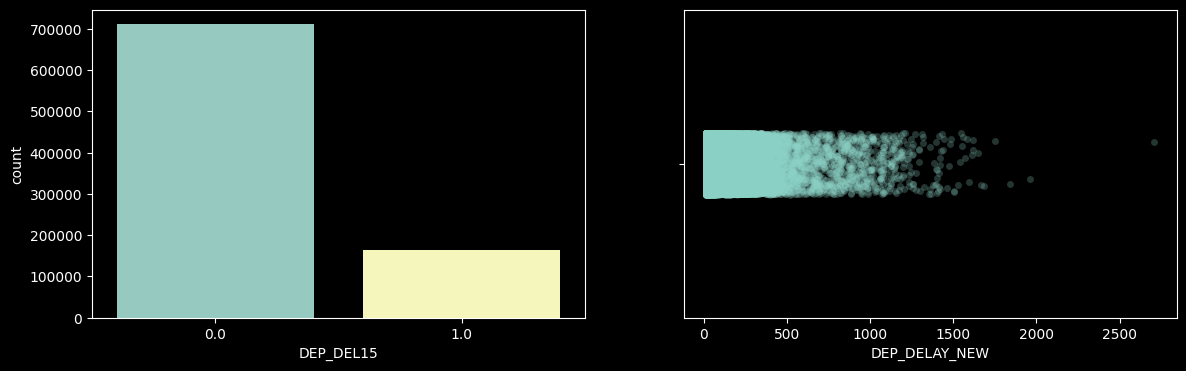

In [5]:
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(14,4))
sns.countplot(data=flights_cleaned_df, x="DEP_DEL15", ax=axs[0]);
sns.stripplot(data=flights_cleaned_df.loc[flights_cleaned_df.DEP_DEL15==1,:], x="DEP_DELAY_NEW", ax=axs[1], alpha=0.25);

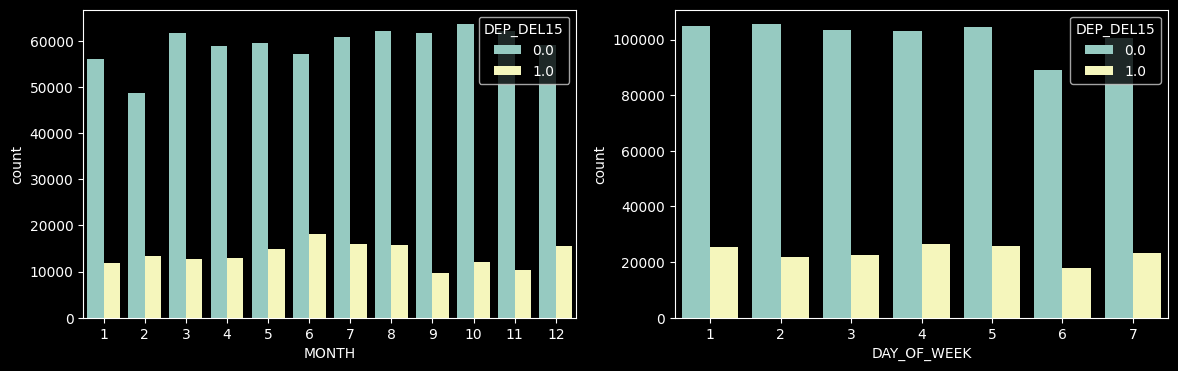

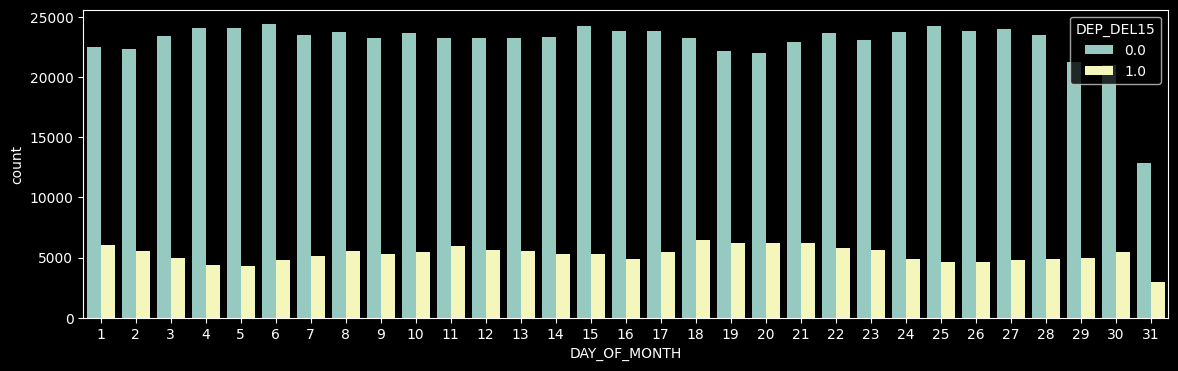

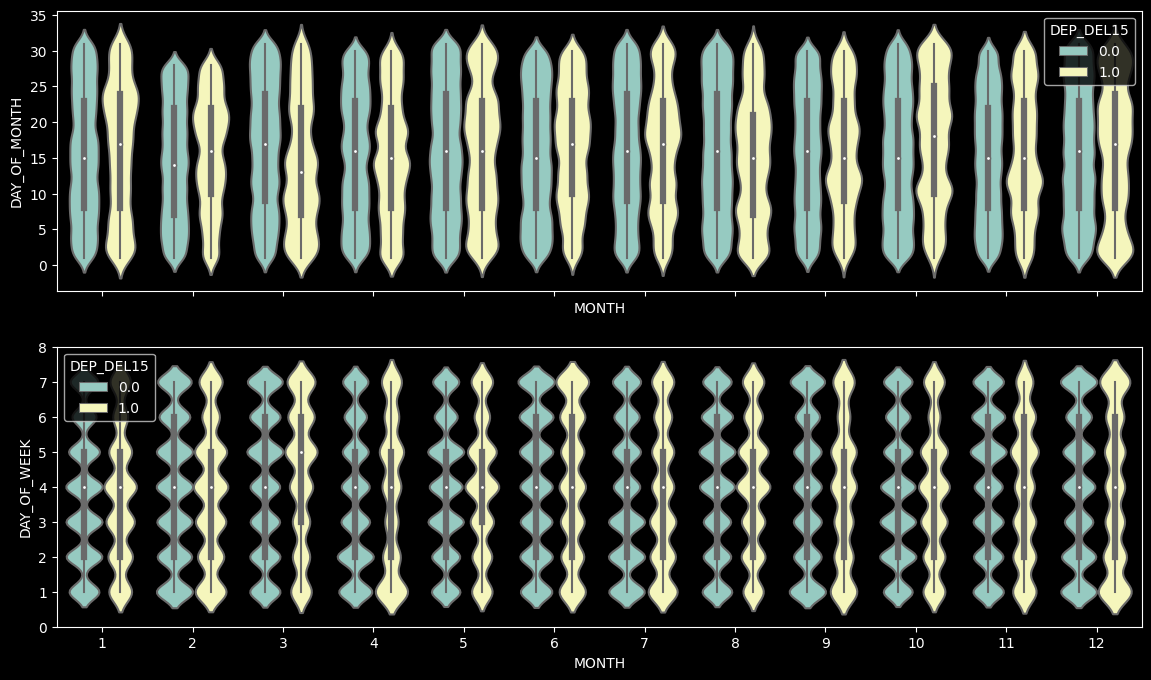

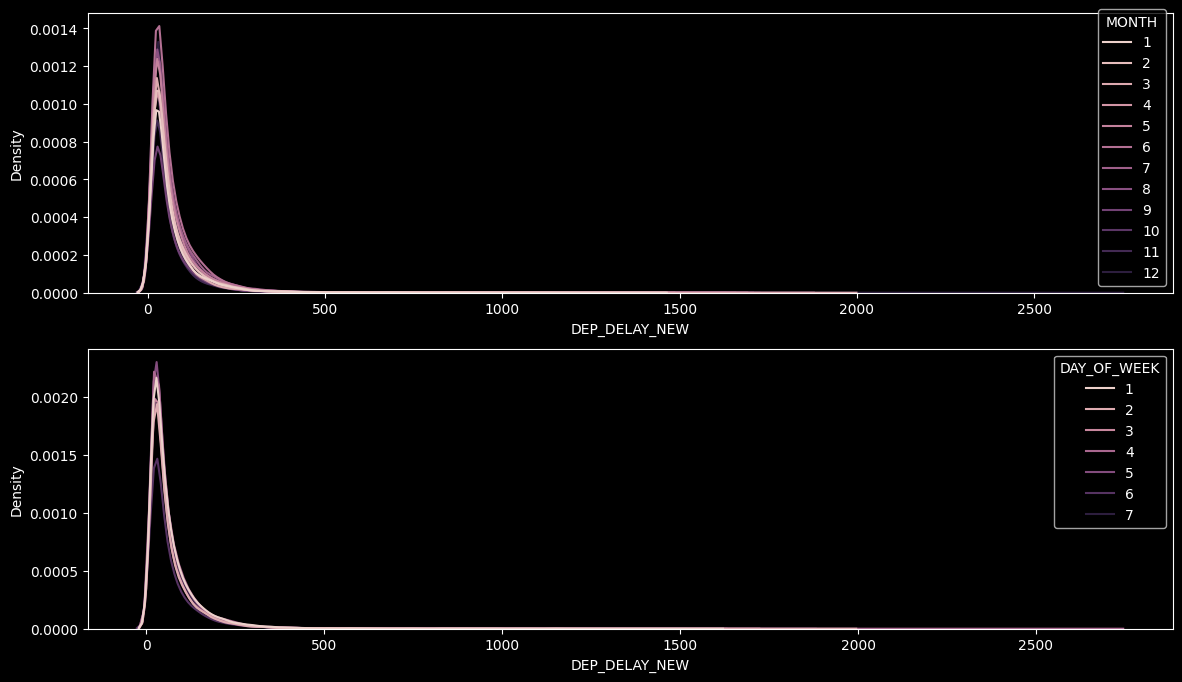

In [6]:
# let's understand the relationship between the targets and the date information we have
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(14,4))
sns.countplot(data=flights_cleaned_df, x="MONTH", hue="DEP_DEL15", ax=axs[0]);
sns.countplot(data=flights_cleaned_df, x="DAY_OF_WEEK", hue="DEP_DEL15", ax=axs[1]);

fig, axs = plt.subplots(ncols=1,nrows=1,figsize=(14,4))
sns.countplot(data=flights_cleaned_df, x="DAY_OF_MONTH", hue="DEP_DEL15", ax=axs);

fig, axs = plt.subplots(ncols=1,nrows=2,figsize=(14,8),sharex=True)
sns.violinplot(data=flights_cleaned_df, x="MONTH", y="DAY_OF_MONTH", hue="DEP_DEL15", ax=axs[0]);
sns.violinplot(data=flights_cleaned_df, x="MONTH", y="DAY_OF_WEEK", hue="DEP_DEL15", ax=axs[1]);

fig, axs = plt.subplots(ncols=1,nrows=2,figsize=(14,8))
sns.kdeplot(
    x=flights_cleaned_df.loc[flights_cleaned_df.DEP_DEL15==1, "DEP_DELAY_NEW"], 
    ax=axs[0], 
    hue=flights_cleaned_df.loc[flights_cleaned_df.DEP_DEL15==1, "MONTH"]
);
sns.kdeplot(
    x=flights_cleaned_df.loc[flights_cleaned_df.DEP_DEL15==1, "DEP_DELAY_NEW"], 
    ax=axs[1], 
    hue=flights_cleaned_df.loc[flights_cleaned_df.DEP_DEL15==1, "DAY_OF_WEEK"]
);

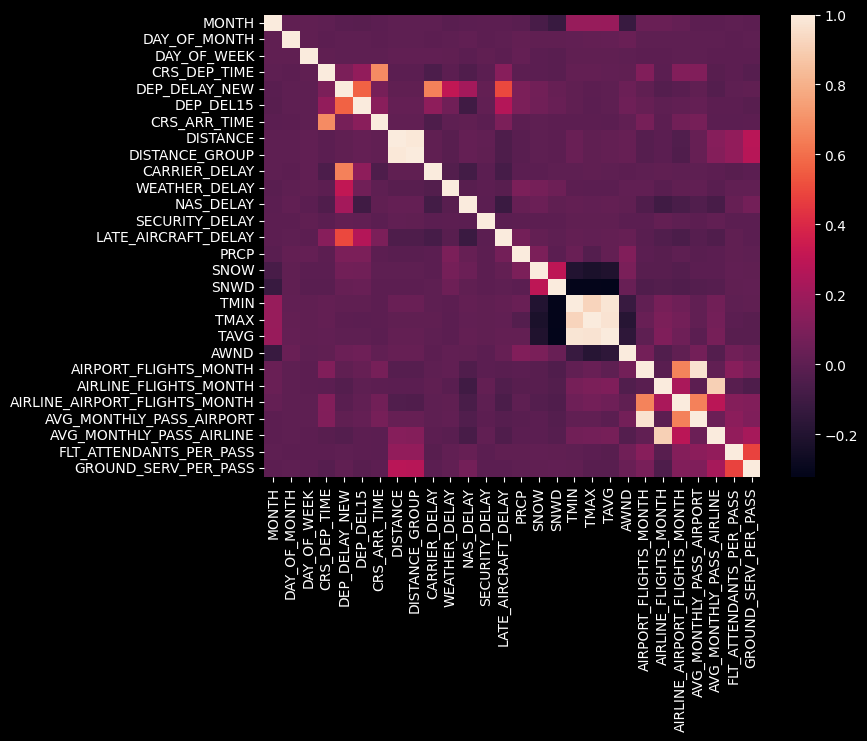

In [7]:
# investigate any problematic collinearity in the data which may indicate mutual information among variables
plt.figure(figsize=(8,6))
sns.heatmap(data=flights_cleaned_df.corr(numeric_only=True));

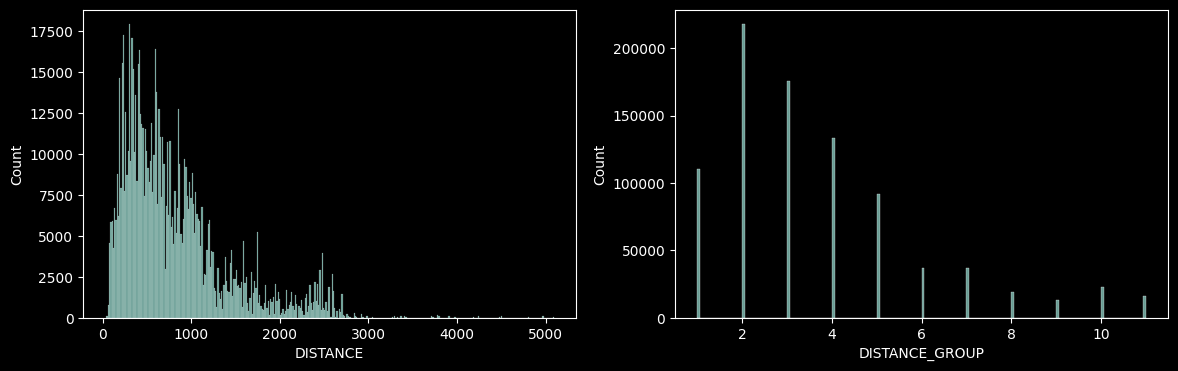

In [8]:
# lets look at the distribution of distance travelled when 
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(14,4))
sns.histplot(x=flights_cleaned_df.DISTANCE, ax=axs[0]);
sns.histplot(x=flights_cleaned_df.DISTANCE_GROUP, ax=axs[1]);

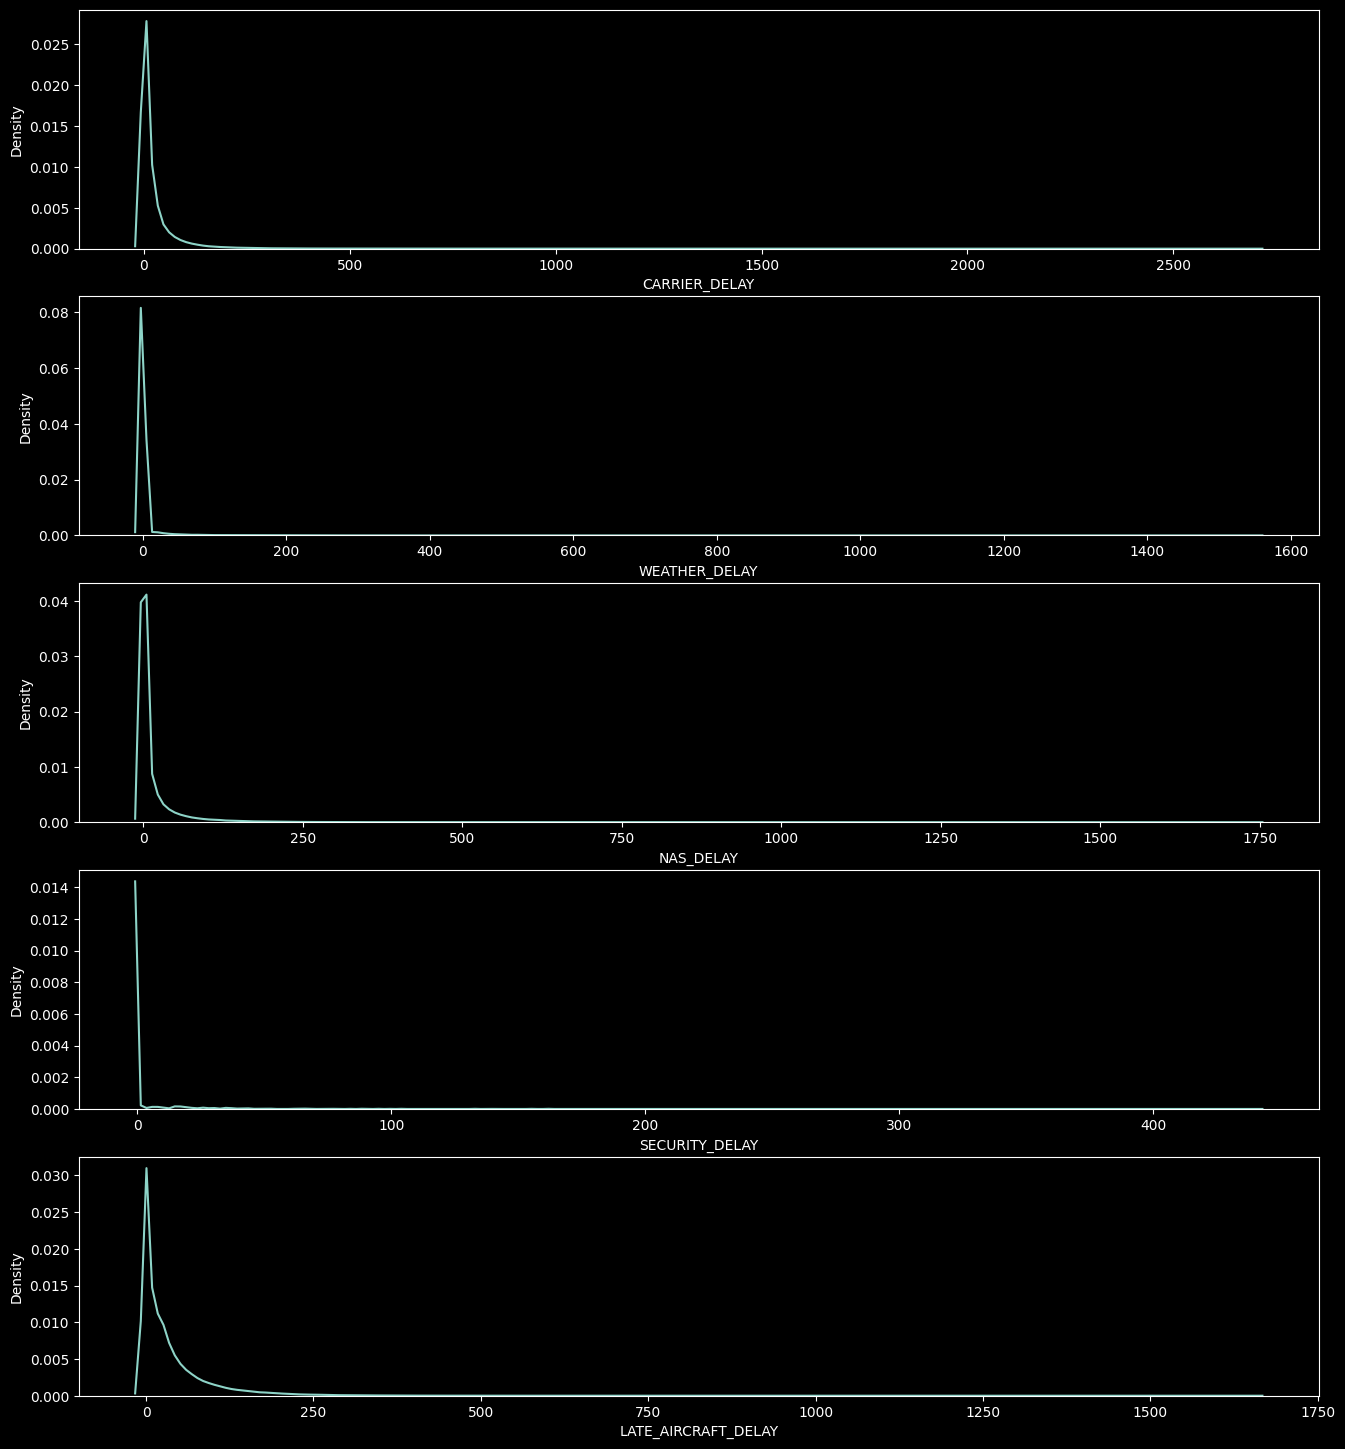

In [9]:
# check out the distribution of flight arrival delay minutes by the type of delay
# interesting but not incredibly relevant to our analysis
fig, axs = plt.subplots(ncols=1,nrows=5,figsize=(16,18))
sns.kdeplot(x=flights_cleaned_df.loc[flights_cleaned_df.DEP_DEL15==1, "CARRIER_DELAY"], ax=axs[0]);
sns.kdeplot(x=flights_cleaned_df.loc[flights_cleaned_df.DEP_DEL15==1, "WEATHER_DELAY"], ax=axs[1]);
sns.kdeplot(x=flights_cleaned_df.loc[flights_cleaned_df.DEP_DEL15==1, "NAS_DELAY"], ax=axs[2]);
sns.kdeplot(x=flights_cleaned_df.loc[flights_cleaned_df.DEP_DEL15==1, "SECURITY_DELAY"], ax=axs[3]);
sns.kdeplot(x=flights_cleaned_df.loc[flights_cleaned_df.DEP_DEL15==1, "LATE_AIRCRAFT_DELAY"], ax=axs[4]);

### Final cleaning & data preprocessing
The plots above help highlight the existence, or lack of, patterns that may hold importance when shifting to predicting the target variables. One notable observation is the class imbalance in the target variable. 

Additionally, looking at the relationship between the target variables and features relating to a flight's departure date, there does not seem to be a significantly observable pattern. These variables would be encoded as categorical in any future model and increase the dimensionality of the data significantly. As a result, we choose to develop a new future, `SEASON`, which contains information about the month of the flight and the date of the flight, leaving the day of the week in for future analysis.

The correlation plot displays the pairwise correlations among features in the data set. There are two regions showing high correlation, with the first containing variables related to flight distance and the second containing features relating to temperature. The grouped measure of distance results in significant information loss relative the raw flight distances, so we opt to drop the grouped distance; additionally, we are unware of how this data was grouped, so including this information could introduce bias into the data. Minimum and maximum temperature observed on the day of a flight would be correlated intuitively, but given we also have the average temperature, these three variables have correlation >90%. Here, we develop a new feature, `TRANGE`, which is the range of the temperature on the given day but is uncorrelated with the other temperature variables. We then keep `TAVG` while dropping min and max temperature.

We drop all the variables that allocate the delayed arrival minutes to a reason and we drop the planned time of departure and arrival in favour of their bucketed versions.

In [10]:
# we create a new feature called SEASON which masks the MONTH and DAY_OF_MONTH variables and helps decrease dimensionality
flights_cleaned_df["SEASON"] = flights_cleaned_df.apply(getSeason, axis=1)

# we create a new feature called TRANGE which captures the dispersion of temperature on the departure date
# using information from TMIN and TMAX, but is minimally correlated with the existing temperature-related variables
flights_cleaned_df["TRANGE"] = flights_cleaned_df.apply(lambda row: row["TMAX"] - row["TMIN"], axis=1)

# we drop variables that are related to the arrival delay to avoid information leakage
# we drop some variables related to date
# we drop some variables related to temperature
flights_cleaned_df = flights_cleaned_df.drop(
    labels=[
        "DEST",
        "CARRIER_DELAY",
        "WEATHER_DELAY",
        "NAS_DELAY",
        "SECURITY_DELAY",
        "LATE_AIRCRAFT_DELAY",
        "MONTH",
        "DAY_OF_MONTH",
        "DAY_OF_WEEK",
        "TMIN",
        "TMAX",
        "DISTANCE_GROUP",
        "AIRLINE_AIRPORT_FLIGHTS_MONTH"
    ],
    axis=1
)

# drop these variables as the planned departure time and arrival time has been binned in another variable 
flights_cleaned_df = flights_cleaned_df.drop(
    labels=[
        "CRS_DEP_TIME",
        "CRS_ARR_TIME",
        "ARR_TIME_BLK"
    ],
    axis=1
)

# peak at the dataframe and its dimensions
print(f"The data has shape: {flights_cleaned_df.shape}")
flights_cleaned_df.head(5)

The data has shape: (874401, 19)


,OP_UNIQUE_CARRIER,ORIGIN,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,DISTANCE,PRCP,SNOW,SNWD,TAVG,AWND,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,SEASON,TRANGE
0,AA,DFW,0.0,0.0,0800-0859,936.0,0.0,NaN,NaN,NaN,6.04,25390.0,76419.0,2907365.0,11744595.0,0.000098,0.000177,summer,23.0
1,OO,FWA,0.0,0.0,0800-0859,508.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,spring,NaN
2,MQ,DFW,0.0,0.0,2200-2259,383.0,0.0,NaN,NaN,NaN,3.36,25322.0,26721.0,2907365.0,1204766.0,0.000348,0.000107,winter,29.0
3,YX,BTV,0.0,0.0,0001-0559,437.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,winter,NaN
4,DL,SFO,3.0,0.0,1200-1259,337.0,0.0,NaN,NaN,53.0,7.61,13989.0,84142.0,1908862.0,12460183.0,0.000144,0.000149,spring,15.0


### Preprocessing
We convert relevant features from numeric to categorical, split the data, and then define the preprocessing steps to execute on each column based on data type - numeric columns will be standardized to have mean 0 and unit variance, while categorical variables will be one-hot encoded.

In [11]:
# convert relevant data to categorical dtyoe
flights_X = flights_cleaned_df.apply(convertCategorical, axis=0)

# split data
flights_ry = flights_X.pop("DEP_DELAY_NEW")
flights_cy = flights_X.pop("DEP_DEL15")

# define mapping for preprocessing steps on each 
feature_definition = mapFeatures(flights_X)
mapper = DataFrameMapper(features=feature_definition)
flights_X = flights_X.apply(convertCategorical, axis=0, coded=True)


## Classification

In [ ]:
k = 8
seed = 123
cpus = cpu_count()
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

results = np.zeros((k, 5))
coefs = {}

model = RandomForestClassifier(n_jobs=cpus, random_state=seed)
for (train_idx, val_idx) in kfold.split(flights_X, flights_cy):
    train_X, train_y = flights_X.iloc[train_idx, :], flights_cy.iloc[train_idx]
    train_X = mapper.fit_transform(train_X)
    model.fit(train_X, train_y)
    

    val_X, val_y = flights_X.iloc[val_idx, :], flights_cy.iloc[val_idx]
    val_X = mapper.transform(val_X)
    val_y_hat = model.predict(val_X)
    

    results[k-1, :] = [
        recall_score(val_y, val_y_hat),
        precision_score(val_y, val_y_hat),
        f1_score(val_y, val_y_hat),
        roc_auc_score(val_y, val_y_hat),
        accuracy_score(val_y, val_y_hat)
    ]
    
    k -= 1

results

In [ ]:
k = 8
seed = 123
cpus = cpu_count()
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

results = np.zeros((k, 5))
coefs = {}

model = RandomForestClassifier(class_weight="balanced", n_jobs=cpus, random_state=seed)
for (train_idx, val_idx) in kfold.split(flights_X, flights_cy):
    train_X, train_y = flights_X.iloc[train_idx, :], flights_cy.iloc[train_idx]
    train_X = mapper.fit_transform(train_X)
    model.fit(train_X, train_y)
    

    val_X, val_y = flights_X.iloc[val_idx, :], flights_cy.iloc[val_idx]
    val_X = mapper.transform(val_X)
    val_y_hat = model.predict(val_X)
    

    results[k-1, :] = [
        recall_score(val_y, val_y_hat),
        precision_score(val_y, val_y_hat),
        f1_score(val_y, val_y_hat),
        roc_auc_score(val_y, val_y_hat),
        accuracy_score(val_y, val_y_hat)
    ]
    
    k -= 1

results

In [ ]:
k = 8
seed = 123
cpus = cpu_count()
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

results = np.zeros((k, 5))
coefs = {}

model = LogisticRegression(max_iter=2000, n_jobs=cpus, random_state=seed)
for (train_idx, val_idx) in kfold.split(flights_X, flights_cy):
    train_X, train_y = flights_X.iloc[train_idx, :], flights_cy.iloc[train_idx]
    train_X = mapper.fit_transform(train_X)
    model.fit(train_X, train_y)
    

    val_X, val_y = flights_X.iloc[val_idx, :], flights_cy.iloc[val_idx]
    val_X = mapper.transform(val_X)
    val_y_hat = model.predict(val_X)
    
    coefs[k] = model.coefs_
    results[k-1, :] = [
        recall_score(val_y, val_y_hat),
        precision_score(val_y, val_y_hat),
        f1_score(val_y, val_y_hat),
        roc_auc_score(val_y, val_y_hat),
        accuracy_score(val_y, val_y_hat)
    ]
    
    k -= 1

results

In [ ]:
k = 8
seed = 123
cpus = cpu_count()
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

results = np.zeros((k, 5))
coefs = {}

model = LogisticRegression(class_weight="balanced", max_iter=2000, n_jobs=cpus, random_state=seed)
for (train_idx, val_idx) in kfold.split(flights_X, flights_cy):
    train_X, train_y = flights_X.iloc[train_idx, :], flights_cy.iloc[train_idx]
    train_X = mapper.fit_transform(train_X)
    model.fit(train_X, train_y)
    

    val_X, val_y = flights_X.iloc[val_idx, :], flights_cy.iloc[val_idx]
    val_X = mapper.transform(val_X)
    val_y_hat = model.predict(val_X)
    
    # coefs[k] = model
    results[k-1, :] = [
        recall_score(val_y, val_y_hat),
        precision_score(val_y, val_y_hat),
        f1_score(val_y, val_y_hat),
        roc_auc_score(val_y, val_y_hat),
        accuracy_score(val_y, val_y_hat)
    ]
    
    k -= 1
results

## Regression

feature_definition